[View in Colaboratory](https://colab.research.google.com/github/Rexnato/jarvis/blob/master/first_steps_with_tensor_flow.ipynb)

#### Copyright 2017 Google LLC.

In [2]:
#@title
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

 # Primeros pasos con TensorFlow

 **Objetivos de aprendizaje:**
  * aprender los conceptos fundamentales de TensorFlow
  * usar la clase `LinearRegressor` en TensorFlow para predecir el precio mediano de la vivienda, en el nivel de detalle de las manzanas, basado en un atributo de entrada
  * evaluar la exactitud de las predicciones de un modelo a través del error de la raíz cuadrada de la media (RMSE)
  * mejorar la exactitud de un modelo al ajustar sus hiperparámetros

 Los datos se basan en el censo que se realizó en 1990 en California.

 ## Preparación
En esta primera celda, cargaremos las bibliotecas necesarias.

In [3]:
#@title
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

 A continuación, cargaremos nuestro conjunto de datos.

In [4]:
#@title
california_housing_dataframe = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_train.csv", sep=",")

 Dispondremos los datos de forma aleatoria para asegurarnos de no obtener efectos de orden compulsivo que podrían afectar el rendimiento del descenso de gradiente estocástico. Además, ajustaremos `median_house_value` para que esté en unidades de miles, de manera que se pueda aprender más fácilmente con tasas de aprendizaje en un rango que usamos generalmente.

In [5]:
#@title
california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe["median_house_value"] /= 1000.0
california_housing_dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
9639,-119.5,36.6,18.0,1404.0,226.0,754.0,229.0,4.0,118.1
11686,-121.3,38.6,29.0,2748.0,563.0,1619.0,525.0,2.9,92.4
13901,-122.0,37.9,21.0,4712.0,624.0,1773.0,615.0,6.1,344.8
16438,-122.6,38.4,27.0,3800.0,728.0,1587.0,605.0,4.7,306.6
15284,-122.3,37.9,52.0,1659.0,367.0,788.0,346.0,2.8,164.3
...,...,...,...,...,...,...,...,...,...
633,-117.0,32.6,14.0,1111.0,142.0,472.0,145.0,7.6,290.5
4829,-118.1,33.9,14.0,2369.0,604.0,1546.0,464.0,3.8,159.4
11767,-121.3,38.7,21.0,1276.0,208.0,501.0,205.0,4.0,143.6
2833,-117.7,33.4,5.0,1889.0,359.0,616.0,246.0,3.9,500.0


 ## Análisis de los datos

Una buena idea es conocer un poco los datos antes de trabajar con ellos.

Imprimiremos un breve resumen de algunas estadísticas útiles de cada columna: conteo de ejemplos, media, desviación estándar, máx., mín. y varios cuantiles.

In [6]:
#@title
california_housing_dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207.3
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,116.0
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,15.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119.4
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180.4
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500.0


 ## Creación del primer modelo

En este ejercicio, intentaremos predecir `median_house_value`, que será nuestra etiqueta (a veces también denominada objetivo). Usaremos `total_rooms` como nuestro atributo de entrada.

**NOTA:** Nuestros datos están a nivel de manzana, de manera que este atributo representa el número total de habitaciones en esa manzana.

Para entrenar nuestro modelo, usaremos la interfaz de [LinearRegressor](https://www.tensorflow.org/api_docs/python/tf/estimator/LinearRegressor) que proporciona la API de [Estimator](https://www.tensorflow.org/get_started/estimator) de TensorFlow. Esta API se ocupa en gran medida del ajuste del modelo de bajo nivel y presenta métodos convenientes para realizar el entrenamiento, la evaluación y la inferencia del modelo.

 ### Paso 1: Define atributos y configura columnas de atributos

In [6]:
#@title


 Para importar nuestros datos de entrenamiento en TensorFlow, debemos especificar qué tipo de datos contiene cada atributo. Hay dos tipos de datos principales que usaremos en este ejercicio y en otros futuros:

* **Datos categóricos**: Datos que son textuales. En este ejercicio, nuestro conjunto de datos de viviendas no contiene atributos categóricos, pero los ejemplos que podrías ver son el estilo de la casa o las palabras en un anuncio de bienes raíces.

* **Datos numéricos**: Datos que son un número (entero o de punto flotante) y que quieres tratar como un número. Como se analizará más adelante, a veces quieres tratar los datos numéricos (p. ej., un código postal) como si fueran categóricos.

En TensorFlow, indicamos el tipo de datos de un atributo a través de un constructo denominado **columna de atributos**. Las columnas de atributos almacenan solo una descripción de los datos de los atributos; no contienen los datos de los atributos en sí.

Para comenzar, usaremos solo un atributo de entrada numérica, `total_rooms`. El siguiente código extrae los datos de `total_rooms` de nuestro `california_housing_dataframe` y define la columna de atributos con `numeric_column`, que especifica que los datos son numéricos:

In [7]:
#@title
# Define the input feature: total_rooms.
my_feature = california_housing_dataframe[["total_rooms"]]

# Configure a numeric feature column for total_rooms.
feature_columns = [tf.feature_column.numeric_column("total_rooms")]

 **NOTA:** La forma de nuestros datos de `total_rooms` es una matriz de una dimensión (una lista del número total de habitaciones por cada manzana). Esta es la forma predeterminada para `numeric_column`, de manera que no tenemos que pasarla como un argumento.

 ### Paso 2: Define el objetivo

 A continuación, definiremos nuestro objetivo, que es `median_house_value`. Nuevamente, podemos extraerlo de nuestro `california_housing_dataframe`:

In [8]:
#@title
# Define the label.
targets = california_housing_dataframe["median_house_value"]

 ### Paso 3: Configura el regresor lineal

 A continuación, configuraremos un modelo de regresión lineal a través de LinearRegressor. Entrenaremos este modelo mediante el `GradientDescentOptimizer`, que implementa el descenso de gradiente estocástico (SGD) de minilote. El argumento `learning_rate` controla el tamaño del paso de gradiente.

**NOTA:** Para estar seguros, también aplicamos [recorte de gradientes](https://developers.google.com/machine-learning/glossary/#gradient_clipping) a nuestro optimizador a través de `clip_gradients_by_norm`. El recorte de gradientes garantiza que la magnitud de los gradientes no se vuelva demasiado grande durante el entrenamiento, lo cual puede provocar que falle el descenso de gradientes. 

In [9]:
#@title
# Use gradient descent as the optimizer for training the model.
my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0000001)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

# Configure the linear regression model with our feature columns and optimizer.
# Set a learning rate of 0.0000001 for Gradient Descent.
linear_regressor = tf.estimator.LinearRegressor(
    feature_columns=feature_columns,
    optimizer=my_optimizer
)

 ### Paso 4: Define la función de entrada

 Para importar nuestros datos de viviendas en California a nuestro `LinearRegressor`, tenemos que definir una función de entrada, que instruye a TensorFlow cómo realizar el procesamiento previo de los datos, además de cómo organizarlos por lotes, aleatorizarlos y repetirlos durante el entrenamiento del modelo.

Primero, convertiremos nuestros datos de atributos de *pandas* a un diccionario de matrices de Numpy. A continuación, podemos usar la [API del conjunto de datos](https://www.tensorflow.org/programmers_guide/datasets) de TensorFlow para construir un objeto de conjunto de datos a partir de nuestros datos y, luego, dividir nuestros datos en lotes de `batch_size` para que se repitan para el número especificado de repeticiones (num_epochs). 

**NOTA:** Cuando el valor predeterminado de `num_epochs=None` se pasa como argumento a la función `repeat()`, los datos de entrada se repiten indefinidamente.

A continuación, si `shuffle` está establecido en `True`, se aleatorizarán los datos de manera tal que se pasen al modelo al azar durante el entrenamiento. El argumento `buffer_size` de la función `shuffle` especifica el tamaño del conjunto de datos del que se tomará una muestra al azar.

Finalmente, nuestra función de entrada construye una variable de iteración para el conjunto de datos y devuelve el siguiente lote de datos al regresor lineal.

In [10]:
#@title
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of one feature.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
  
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified
    if shuffle:
      ds = ds.shuffle(buffer_size=10000)
    
    # Return the next batch of data
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

 **NOTA:** Seguiremos usando esta misma función de entrada en ejercicios posteriores. Para obtener documentación más detallada de las funciones de entrada y la API del `Dataset`, consulta la [Guía para programadores de TensorFlow](https://www.tensorflow.org/programmers_guide/datasets).

 ### Paso 5: Entrena el modelo

 Ahora podemos llamar a `train()` en nuestro `linear_regressor` para entrenar el modelo. Uniremos `my_input_fn` en una `lambda` para poder pasar `my_feature` y `target` como argumentos (para obtener más detalles, consulta este [instructivo sobre funciones de entrada de TensorFlow](https://www.tensorflow.org/get_started/input_fn#passing_input_fn_data_to_your_model)) y, para comenzar, entrenaremos el modelo para 100 pasos.

In [11]:
#@title
_ = linear_regressor.train(
    input_fn = lambda:my_input_fn(my_feature, targets),
    steps=100
)

 ### Paso 6: Evalúa el modelo

 Realicemos predicciones sobre los datos de entrenamiento para ver qué tan bien los ajustó nuestro modelo durante el entrenamiento.
**NOTA:** El error de entrenamiento mide qué tan bien ajusta los datos de entrenamiento tu modelo, pero **_no_** mide qué tan bien el modelo **_realiza generalizaciones con respecto a los datos nuevos_**. En ejercicios posteriores, explorarás cómo dividir los datos para evaluar la capacidad del modelo para realizar generalizaciones.


In [12]:
#@title
# Create an input function for predictions.
# Note: Since we're making just one prediction for each example, we don't 
# need to repeat or shuffle the data here.
prediction_input_fn =lambda: my_input_fn(my_feature, targets, num_epochs=1, shuffle=False)

# Call predict() on the linear_regressor to make predictions.
predictions = linear_regressor.predict(input_fn=prediction_input_fn)

# Format predictions as a NumPy array, so we can calculate error metrics.
predictions = np.array([item['predictions'][0] for item in predictions])

# Print Mean Squared Error and Root Mean Squared Error.
mean_squared_error = metrics.mean_squared_error(predictions, targets)
root_mean_squared_error = math.sqrt(mean_squared_error)
print("Mean Squared Error (on training data): %0.3f" % mean_squared_error)
print("Root Mean Squared Error (on training data): %0.3f" % root_mean_squared_error)

Mean Squared Error (on training data): 56367.025
Root Mean Squared Error (on training data): 237.417


 ¿Este es un buen modelo? ¿Cómo determinarías la magnitud de este error?

El error cuadrático medio (MSE) puede ser difícil de interpretar; es por esto que generalmente observamos el error de la raíz cuadrada de la media (RMSE) en su lugar. Una propiedad interesante del RMSE es que se puede interpretar en la misma escala que los objetivos originales.

Comparemos el RMSE con la diferencia del mín. y el máx. de nuestros objetivos:

In [13]:
#@title
min_house_value = california_housing_dataframe["median_house_value"].min()
max_house_value = california_housing_dataframe["median_house_value"].max()
min_max_difference = max_house_value - min_house_value

print("Min. Median House Value: %0.3f" % min_house_value)
print("Max. Median House Value: %0.3f" % max_house_value)
print("Difference between Min. and Max.: %0.3f" % min_max_difference)
print("Root Mean Squared Error: %0.3f" % root_mean_squared_error)

Min. Median House Value: 14.999
Max. Median House Value: 500.001
Difference between Min. and Max.: 485.002
Root Mean Squared Error: 237.417


 Nuestro error abarca casi la mitad del rango de los valores objetivo. ¿Podemos obtener un mejor desempeño?

Esta es la pregunta que molesta a todo programador de modelos. Desarrollemos algunas estrategias básicas para reducir el error del modelo.

Lo primero que podemos hacer es observar qué tan bien coinciden nuestras predicciones con nuestros objetivos, en términos de estadísticas generales de resumen.

In [14]:
#@title
calibration_data = pd.DataFrame()
calibration_data["predictions"] = pd.Series(predictions)
calibration_data["targets"] = pd.Series(targets)
calibration_data.describe()

,predictions,targets
count,17000.0,17000.0
mean,0.1,207.3
std,0.1,116.0
min,0.0,15.0
25%,0.1,119.4
50%,0.1,180.4
75%,0.2,265.0
max,1.9,500.0


 Bien, es posible que esta información resulte útil. ¿Cómo se compara el valor medio con el RMSE del modelo? ¿Qué ocurre con los diferentes cuantiles?

También podemos visualizar los datos y la línea que aprendimos. Recuerda que la regresión lineal en un solo atributo puede representarse como una línea que asigna la entrada *x* al resultado *y*.

Primero, obtendremos una muestra aleatoria uniforme de los datos para poder realizar una representación de dispersión que se pueda leer.

In [15]:
#@title
sample = california_housing_dataframe.sample(n=300)

 A continuación, representaremos la línea que aprendimos, dibujándola a partir del término de ordenada al origen y la ponderación del atributo del modelo, junto con la representación de dispersión. La línea se mostrará de color rojo.

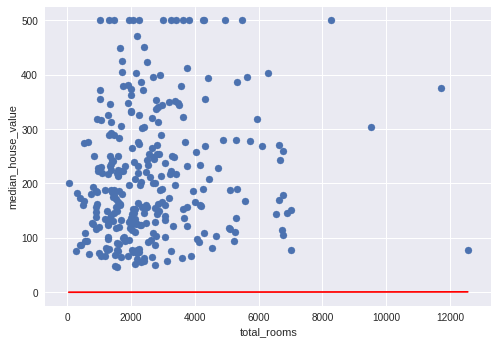

In [16]:
#@title
# Get the min and max total_rooms values.
x_0 = sample["total_rooms"].min()
x_1 = sample["total_rooms"].max()

# Retrieve the final weight and bias generated during training.
weight = linear_regressor.get_variable_value('linear/linear_model/total_rooms/weights')[0]
bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

# Get the predicted median_house_values for the min and max total_rooms values.
y_0 = weight * x_0 + bias 
y_1 = weight * x_1 + bias

# Plot our regression line from (x_0, y_0) to (x_1, y_1).
plt.plot([x_0, x_1], [y_0, y_1], c='r')

# Label the graph axes.
plt.ylabel("median_house_value")
plt.xlabel("total_rooms")

# Plot a scatter plot from our data sample.
plt.scatter(sample["total_rooms"], sample["median_house_value"])

# Display graph.
plt.show()

 Esta línea inicial se ve muy alejada. Fíjate si puedes observar las estadísticas de resumen y ver la misma información codificada allí.

En conjunto, estos controles de estado sugieren que posiblemente podamos encontrar una línea mucho más satisfactoria.

 ## Ajuste de los hiperparámetros del modelo
Para este ejercicio, colocamos todo el código anterior en una sola función por cuestiones prácticas. Puedes llamar a la función con diferentes parámetros para ver el efecto.

En esta función, procederemos en 10 períodos divididos uniformemente para poder observar la mejora del modelo en cada período.

Para cada período, computaremos y graficaremos la pérdida de entrenamiento. Esto puede ayudarte a determinar cuándo converge un modelo o si este necesita más iteraciones.

También representaremos los valores de ponderación de atributos y término de ordenada al origen aprendidos por el modelo en el tiempo. Esta es otra forma de ver cómo convergen los elementos.

In [17]:
#@title
def train_model(learning_rate, steps, batch_size, input_feature="total_rooms"):
  """Trains a linear regression model of one feature.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    input_feature: A `string` specifying a column from `california_housing_dataframe`
      to use as input feature.
  """
  
  periods = 10
  steps_per_period = steps / periods

  my_feature = input_feature
  my_feature_data = california_housing_dataframe[[my_feature]]
  my_label = "median_house_value"
  targets = california_housing_dataframe[my_label]

  # Create feature columns
  feature_columns = [tf.feature_column.numeric_column(my_feature)]
  
  # Create input functions
  training_input_fn = lambda:my_input_fn(my_feature_data, targets, batch_size=batch_size)
  prediction_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)
  
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )

  # Set up to plot the state of our model's line each period.
  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.title("Learned Line by Period")
  plt.ylabel(my_label)
  plt.xlabel(my_feature)
  sample = california_housing_dataframe.sample(n=300)
  plt.scatter(sample[my_feature], sample[my_label])
  colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  root_mean_squared_errors = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    predictions = linear_regressor.predict(input_fn=prediction_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    
    # Compute loss.
    root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(predictions, targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    root_mean_squared_errors.append(root_mean_squared_error)
    # Finally, track the weights and biases over time.
    # Apply some math to ensure that the data and line are plotted neatly.
    y_extents = np.array([0, sample[my_label].max()])
    
    weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
    bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

    x_extents = (y_extents - bias) / weight
    x_extents = np.maximum(np.minimum(x_extents,
                                      sample[my_feature].max()),
                           sample[my_feature].min())
    y_extents = weight * x_extents + bias
    plt.plot(x_extents, y_extents, color=colors[period]) 
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.subplot(1, 2, 2)
  plt.ylabel('RMSE')
  plt.xlabel('Periods')
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(root_mean_squared_errors)

  # Output a table with calibration data.
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  display.display(calibration_data.describe())

  print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)

 ## Tarea 1: Logra un RMSE de 180 o más bajo

Ajusta los hiperparámetros del modelo para mejorar la pérdida y adaptar mejor la distribución objetivo.
Si después de aproximadamente 5 minutos tienes problemas para obtener un RMSE de 180 o más bajo, comprueba la solución para conocer una combinación posible.

Training model...
RMSE (on training data):
  period 00 : 236.32
  period 01 : 235.11
  period 02 : 233.90
  period 03 : 232.70
  period 04 : 231.50
  period 05 : 230.31
  period 06 : 229.13
  period 07 : 227.96
  period 08 : 226.79
  period 09 : 225.63
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,13.2,207.3
std,10.9,116.0
min,0.0,15.0
25%,7.3,119.4
50%,10.6,180.4
75%,15.8,265.0
max,189.7,500.0


Final RMSE (on training data): 225.63


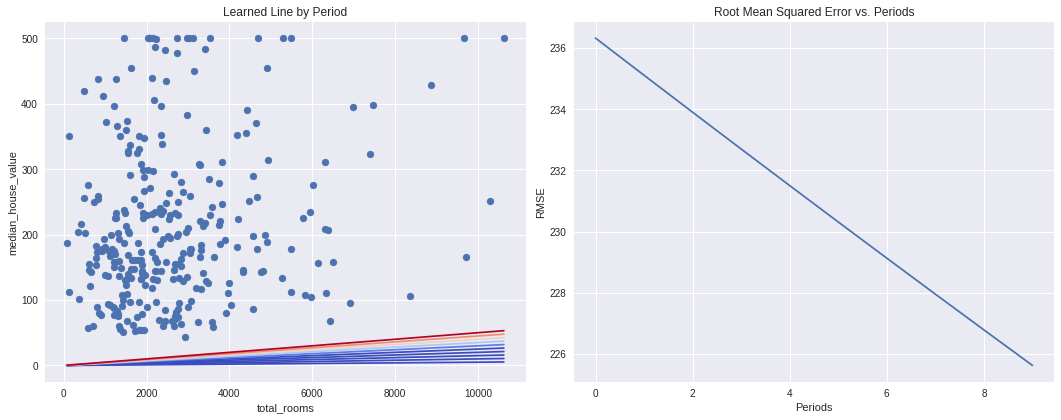

In [18]:
#@title
train_model(
    learning_rate=0.00001,
    steps=100,
    batch_size=1
)

 ### Solución

Haz clic más abajo para conocer una solución posible.

In [0]:
#@title
train_model(
    learning_rate=0.00002,
    steps=500,
    batch_size=5
)

Training model...
RMSE (on training data):
  period 00 : 225.63
  period 01 : 214.42
  period 02 : 204.44
  period 03 : 195.33
  period 04 : 187.23


 Esta es solo una configuración posible; es posible que existan otras combinaciones de configuraciones que también den buenos resultados. Ten en cuenta que, en general, este ejercicio no se trata de buscar la *mejor* configuración, sino de ayudarte a desarrollar tu intuición sobre cómo el ajuste de la configuración del modelo afecta la calidad de la predicción.

 ### ¿Hay una heurística estándar para el ajuste del modelo?

Esta es una pregunta frecuente. La respuesta breve es que los efectos de los diferentes hiperparámetros dependen de los datos. Por lo tanto, no hay reglas estrictas; debes probarlos en tus datos.

Dicho esto, aquí se incluyen algunas reglas generales que pueden ayudarte como guía:

 * El error de entrenamiento debe disminuir constantemente, de manera abrupta al principio y eventualmente estancarse a medida que converge el entrenamiento.
 * Si el entrenamiento no convirgió, prueba ejecutarlo durante más tiempo.
 * Si el error de entrenamiento disminuye muy lentamente, aumentar la tasa de entrenamiento puede ayudar a que disminuya más rápido.
   * Sin embargo, en algunas ocasiones puede ocurrir exactamente lo opuesto si la tasa de aprendizaje es demasiado alta.
 * Si el error de entrenamiento varía extremadamente, prueba disminuir la tasa de aprendizaje.
   * Una tasa de aprendizaje más baja con un número más alto de pasos o un tamaño del lote más grande suelen ser una buena combinación.
 * Los tamaños del lote muy pequeños también pueden causar inestabilidad. Primero prueba valores más altos, como 100 o 1,000, y disminúyelos hasta que observes degradación.

Como dijimos antes, nunca te rijas estrictamente por estas reglas generales, porque los efectos dependen de los datos. Siempre debes experimentar y verificar.

 ## Tarea 2: Prueba un atributo diferente

Observa si puedes obtener un mejor desempeño al reemplazar el atributo `total_rooms` por el atributo `population`.

No dediques más de 5 minutos a esta actividad.

In [0]:
#@title
# YOUR CODE HERE

 ### Solución

Haz clic más abajo para conocer una solución posible.

In [0]:
#@title
train_model(
    learning_rate=0.00002,
    steps=1000,
    batch_size=5,
    input_feature="population"
)